# CS596 final project

## Blind source separation with artificial neural networks

#### Authors
<pre style="font-size: 120%">
Daniel Correa Tucunduva  002228689
Siqian Liu               002240226
Weina Zhu                002242570
Yan Jiang                002271130
</pre>

#### Credit
<pre style="font-size: 120%">
Data generation, fastICA and results plot code adapted from:
https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html

Neural network code adapted from:
https://raw.githubusercontent.com/abhijeet3922/Object-recognition-CIFAR-10/master/cifar10_90.py
</pre>

## Setup

In [1]:
# Hyperparameters

N = 20000  # time points for synthetic data generation for training
T = 10000  # time points for synthetic data generation for testing

epochs = 20
batch_size = 100

In [2]:
# Utility library

def random_weight():
    # a random weight in the range [0.01, 1.00]
    return round(np.random.randint(1, 101) / 100.0, 2)

def learning_rate_schedule(epoch):
    if epoch > 15:
        return 0.00025
    if epoch > 10:
        return 0.0005
    return 0.001

def save_generated_data_to_disk():
    # weights and observations have to be flattened to 2d arrays to allow saving as .csv
    flat_weights = np.zeros((GRID_ROWS * GRID_COLUMNS, 3))
    row = 0
    for i in range(GRID_ROWS):
        for j in range(GRID_COLUMNS):
            flat_weights[row] = weights[i][j]
            row += 1
    
    flat_observations = np.zeros((N + T, GRID_ROWS * GRID_COLUMNS))
    for nt in range(N + T):
        flat_observations[nt] = np.ravel(observations[nt])
    
    np.savetxt('true_sources.csv', true_sources, delimiter=',', fmt='%1.2f')
    np.savetxt('true_sources_noisy.csv', true_sources_noisy, delimiter=',', fmt='%1.2f')
    np.savetxt('flat_weights.csv', flat_weights, delimiter=',', fmt='%1.2f')
    np.savetxt('flat_observations.csv', flat_observations, delimiter=',', fmt='%1.2f')

def save_cnn_to_disk():
    cnn_json = cnn.to_json()
    with open('cnn.json', 'w') as json_file:
        json_file.write(cnn_json)
    cnn.save_weights('cnn.h5')
    
def save_dense_network_to_disk():
    dense_json = dense.to_json()
    with open('dense.json', 'w') as json_file:
        json_file.write(dense_json)
    dense.save_weights('dense.h5')

In [3]:
# Module setup

print(__doc__)

import numpy as np

from scipy import signal

import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler

from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


Using TensorFlow backend.


## Data generation

In [4]:
# Generate synthetic data

np.random.seed(0)

GRID_ROWS = 10
GRID_COLUMNS = 10

time = np.linspace(0, (N + T) // 500, N + T)

s1 = np.sin(2 * time) # sinusoidal signal
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time) # saw tooth signal

# limit generated values to two decimals
for nt in range(N + T):
    s1[nt] = round(s1[nt], 2)
    s2[nt] = round(s2[nt], 2)
    s3[nt] = round(s3[nt], 2)

# random non-zero weights
weights = np.zeros((GRID_ROWS, GRID_COLUMNS, 3))
for i in range(GRID_ROWS):
    for j in range(GRID_COLUMNS):
        weights[i][j][0] = random_weight()
        weights[i][j][1] = random_weight()
        weights[i][j][2] = random_weight()

true_sources = np.c_[s1, s2, s3] # [N + T x 3], from signal tracks
true_sources /= true_sources.std(axis=0) # standardize
true_sources_noisy = true_sources + 0.15 * np.random.normal(size=true_sources.shape) # add noise

# [N + T x 10 x 10], linear combinations of signals using random non-zero weights
observations = np.zeros((N + T, GRID_ROWS, GRID_COLUMNS, 1))
for nt in range(N + T):
    for i in range(GRID_ROWS):
        for j in range(GRID_COLUMNS):
            linear_combination = weights[i][j][0] * true_sources_noisy[nt][0] +\
                                 weights[i][j][1] * true_sources_noisy[nt][1] +\
                                 weights[i][j][2] * true_sources_noisy[nt][2]
            observations[nt][i][j][0] = round(linear_combination, 2)

print('True sources shape: ', true_sources.shape)
print('Weights shape: ', weights.shape)
print('Observations shape: ', observations.shape)

save_generated_data_to_disk()

True sources shape:  (30000, 3)
Weights shape:  (10, 10, 3)
Observations shape:  (30000, 10, 10, 1)


In [5]:
# Split data into training and testing

true_sources_train = true_sources[:N]
true_sources_test = true_sources[N:]

true_sources_noisy_train = true_sources_noisy[:N]
true_sources_noisy_test = true_sources_noisy[N:]

observations_train = observations[:N]
observations_test = observations[N:]

print('True sources train shape: ', true_sources_train.shape)
print('True sources test shape: ', true_sources_test.shape)

True sources train shape:  (20000, 3)
True sources test shape:  (10000, 3)


## Neural networks and training

In [6]:
# CNN architecture

weight_decay = 1e-4
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=observations.shape[1:]))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))
cnn.add(Flatten())
cnn.add(Dense(3, activation='linear'))

cnn.summary()

optimizer_cnn = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
cnn.compile(loss='mean_squared_error', optimizer=optimizer_cnn)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 10, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)         

In [7]:
# CNN training

generator = ImageDataGenerator()
history_cnn = cnn.fit_generator(
    generator.flow(observations_train, true_sources_noisy_train, batch_size=batch_size),
    steps_per_epoch=observations_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[LearningRateScheduler(learning_rate_schedule)]
)

save_cnn_to_disk()

Epoch 1/20
200/200 [==============================] - 9s 44ms/step - loss: 0.9935
Epoch 2/20
200/200 [==============================] - 7s 37ms/step - loss: 0.0640
Epoch 3/20
200/200 [==============================] - 8s 42ms/step - loss: 0.0449
Epoch 4/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0394
Epoch 5/20
200/200 [==============================] - 8s 38ms/step - loss: 0.0360
Epoch 6/20
200/200 [==============================] - 9s 44ms/step - loss: 0.0345
Epoch 7/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0330
Epoch 8/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0324
Epoch 9/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0316
Epoch 10/20
200/200 [==============================] - 9s 44ms/step - loss: 0.0313
Epoch 11/20
200/200 [==============================] - 9s 44ms/step - loss: 0.0308
Epoch 12/20
200/200 [==============================] - 8s 39ms/step - loss: 0.0271
Epoch 13/20
2

In [8]:
# Dense architecture

dense = Sequential()
dense.add(Dense(32, input_shape=observations.shape[1:]))
dense.add(Dense(64))
dense.add(Dense(64))
dense.add(Dense(128))
dense.add(Flatten())
dense.add(Dense(3, activation='linear'))

dense.summary()

optimizer_dense = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
dense.compile(loss='mean_squared_error', optimizer=optimizer_dense)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10, 10, 32)        64        
_________________________________________________________________
dense_3 (Dense)              (None, 10, 10, 64)        2112      
_________________________________________________________________
dense_4 (Dense)              (None, 10, 10, 64)        4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10, 10, 128)       8320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 38403     
Total params: 53,059
Trainable params: 53,059
Non-trainable params: 0
__________________________________________________

In [9]:
# Dense network training

generator = ImageDataGenerator()
history_dense = dense.fit_generator(
    generator.flow(observations_train, true_sources_noisy_train, batch_size=batch_size),
    steps_per_epoch=observations_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[LearningRateScheduler(learning_rate_schedule)]
)

save_dense_network_to_disk()

Epoch 1/20
200/200 [==============================] - 2s 12ms/step - loss: 0.1444
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0378
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0268
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0247
Epoch 5/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0170
Epoch 6/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0141
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0136
Epoch 8/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0119
Epoch 9/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0104
Epoch 10/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0093
Epoch 11/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0081
Epoch 12/20
200/200 [==============================] - 3s 13ms/step - loss: 0.0012
Epoch 13/20
2

## Network predictions for test data

In [10]:
# Compute CNN and Dense network predictions

signals_cnn = cnn.predict(observations_test) 
signals_dense = dense.predict(observations_test)

## ICA applied on test data

In [11]:
# Compute ICA result

# create [T x 100] track for ICA processing
ica_track = np.zeros((T, 100))
for t in range(T):
    for i in range(10):
        for j in range(10):
            ica_track[t][i * 10 + j] = observations_test[t][i][j][0]


# heuristic to handle randomness in FastICA y-axis orientation
signals_ica = np.zeros((T, 3))
min_mean_squared_error = float('inf')
while min_mean_squared_error > 0.5:
    ica = FastICA(n_components=3, random_state=np.random.randint(1, 101))
    unordered_signals_ica = ica.fit_transform(ica_track) # reconstruct signals
    unordered_signals_ica = np.array(unordered_signals_ica)
    unordered_signals_ica *= 100 # rescale signals
    
    # rearrange reconstructed signal tracks by smallest MSE against true source tracks
    t = unordered_signals_ica.transpose()
    candidates = [
        np.array([t[0], t[1], t[2]]).transpose(),
        np.array([t[0], t[2], t[1]]).transpose(),
        np.array([t[1], t[0], t[2]]).transpose(),
        np.array([t[1], t[2], t[0]]).transpose(),
        np.array([t[2], t[0], t[1]]).transpose(),
        np.array([t[2], t[1], t[0]]).transpose()
    ]
    mean_squared_errors = [
        mean_squared_error(true_sources_test, candidates[0]),
        mean_squared_error(true_sources_test, candidates[1]),
        mean_squared_error(true_sources_test, candidates[2]),
        mean_squared_error(true_sources_test, candidates[3]),
        mean_squared_error(true_sources_test, candidates[4]),
        mean_squared_error(true_sources_test, candidates[5])
    ]
    min_mean_squared_error = min(mean_squared_errors)
    index = mean_squared_errors.index(min_mean_squared_error)
    signals_ica = candidates[index]

## Results

In [12]:
# Compute mean squared error between results and original noise-free sources

cnn_mean_squared_error = mean_squared_error(true_sources_test, signals_cnn)
dense_mean_squared_error = mean_squared_error(true_sources_test, signals_dense)
ica_mean_squared_error = mean_squared_error(true_sources_test, signals_ica)

print('')
print('Mean squared error of results against original noise-free sources:')
print('')
print('CNN           : {}'.format(cnn_mean_squared_error))
print('')
print('Dense network : {}'.format(dense_mean_squared_error))
print('')
print('ICA           : {}'.format(ica_mean_squared_error))
print('')


Mean squared error of results against original noise-free sources:

CNN           : 0.021047142522708576

Dense network : 0.022086772645980423

ICA           : 0.02336004857096562



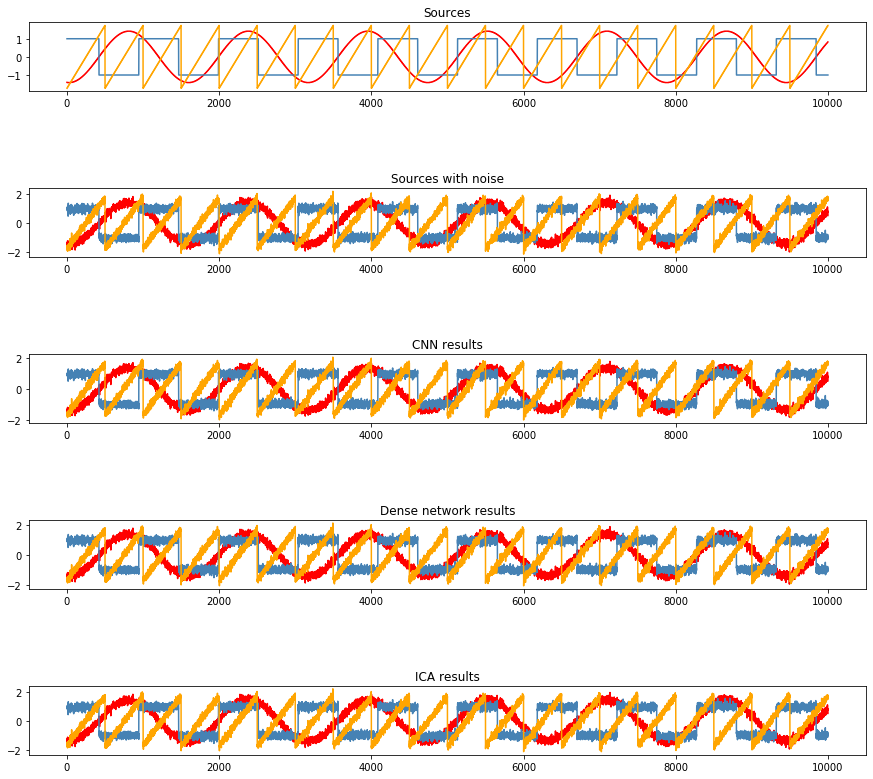

In [13]:
# Create plot of test data

plt.figure(figsize=(15, 15))

models = [true_sources_test, true_sources_noisy_test, signals_cnn, signals_dense, signals_ica]
names = ['Sources', 'Sources with noise', 'CNN results', 'Dense network results', 'ICA results']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(10, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.show()
